In [9]:
import os
import requests
import uuid
from io import BytesIO
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
from keras.models import Model
from keras import layers
from keras.regularizers import l2

import matplotlib.pyplot as plt
import hashlib
import logging

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("smote_process.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

print(f'Tensonrflow: {tf.version.VERSION}')
print(f'Keras: {tf.keras.__version__}')

Tensonrflow: 2.10.0
Keras: 2.10.0


In [5]:
# 1. Configuración inicial
LOCAL_IMAGE_PATH = './repo_dataset'
TARGET_SIZE = (224, 224)
TARGET_SIZE_CHANNEL = (224, 224, 3)
BATCH_SIZE = 32

# Columnas de clases
LABEL_COLUMNS = ['direccion', 'fachada', 'envio', 'etiqueta']

#cargar csv y dividir en dev set y test set
# Load the dataset into a DataFrame
#CSV_PATH = '.\mobilnet-multi-label-solo-local.csv'
#CSV_PATH = '.\mobilnet-multi-label.csv'
#CSV_PATH = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH = '.\mobilnet-multi-label-train-80.csv'
CSV_PATH_DEV = '.\mobilnet-multi-label-dev-test-50.csv'
CSV_PATH_TEST = '.\mobilnet-multi-label-test-50.csv'

In [ ]:
sample_df = pd.read_csv(CSV_PATH_DEV)
print(f'Length dataset {len(sample_df)}')

In [7]:
# cargar las imagenes
def prepare_image(row, local_image_path, label_columns, target_size):
    # Preparar las etiquetas
    labels = row[label_columns].values.astype(int)
 
    try:
        # Cargar desde archivo local
        img_path = os.path.join(local_image_path, row['filename'])
        if os.path.exists(img_path):
            image = Image.open(img_path)
        elif pd.notna(row['urlAbsoluta']):    
             urlAbsoluta = row['urlAbsoluta']
             if 'http' in urlAbsoluta:
                 # Descargar la imagen desde la URL
                 response = requests.get(row['urlAbsoluta'], stream=True, timeout=10)
                 if response.status_code == 200:
                     image = Image.open(BytesIO(response.content))
                     #guardar local para el siguiente ciclo de entrenamiento/prueba
                     image.save(img_path)
             elif os.path.exists(urlAbsoluta):
                 image = Image.open(urlAbsoluta)
             else:
                 raise Exception(f'Error cargando {urlAbsoluta}, archivo no encontrado')
    
        # Convertir a RGB (en caso de que la imagen esté en otro formato, como RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Redimensionar la imagen
        image = image.resize(target_size)  # Redimensionar a 224x224 para MobileNetV3
        
        # Convertir a un array de numpy y normalizar
        image = np.array(image) / 255.0  # Normalizar
        
        return image, np.array(labels)
    except BaseException as e:
        print(f'Error en: {img_path}, Excepción: {str(e)}')
        return None


def prepare_dataset(df, local_image_path, label_columns, target_size, max_workers=4):
    labels = []
    images = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Procesar cada fila del DataFrame
        futures = [executor.submit(prepare_image, row, local_image_path, label_columns, target_size) 
                   for _, row in df.iterrows()]
          
        # Recolectar resultados con barra de progreso
        for future in tqdm(futures, total=len(df)):
            result = future.result()
            if result is not None:
                img_array, img_labels = result
                images.append(img_array)
                labels.append(img_labels)

    # Convertir a arrays numpy
    X = np.array(images)
    y = np.array(labels)

    return X, y

def print_class_distribution(X, y, label_columns):
    print(f"Dataset preparado con {len(X)} imágenes")
    print(f"Distribución de clases:")
    for i, col in enumerate(label_columns):
        positive_samples = np.sum(y[:, i])
        percentage = (positive_samples / len(y)) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{len(y)})")


def print_class_distribution_from_csv(csv_path, label_columns):
    """
    Imprime la distribución de clases leyendo desde un archivo CSV
    
    Parámetros:
    csv_path: str - Ruta al archivo CSV
    label_columns: list - Lista de nombres de las columnas de etiquetas
    """
    # Leer solo las columnas necesarias del CSV
    df = pd.read_csv(csv_path, usecols=label_columns)
    total_samples = len(df)
    frecuencias = [0] * len(label_columns)
    
    print(f"Dataset preparado con {total_samples} imágenes")
    print(f"Distribución de clases:")
    
    for idx, col in enumerate(label_columns):
        positive_samples = df[col].sum()
        percentage = (positive_samples / total_samples) * 100
        print(f"{col}: {percentage:.2f}% ({int(positive_samples)}/{total_samples})")
        frecuencias[idx] = positive_samples
    return total_samples, frecuencias

In [8]:
def batch_loader(csv_path, local_image_path, label_columns, target_size, batch_size=32):
    """Generador de lotes de ejemplo"""
    df = pd.read_csv(csv_path)
    total_samples = len(df)
    
    for start in range(0, total_samples, batch_size):
        batch = df.iloc[start:start+batch_size]
        X_batch = []
        y_batch = []
        
        for _, row in batch.iterrows():
            result = prepare_image(row, local_image_path, label_columns, target_size)
            if result is not None:
                img_array, img_labels = result
                X_batch.append(img_array)
                y_batch.append(img_labels)
            else: 
                continue
        
        yield np.array(X_batch), np.array(y_batch)

In [22]:
sample_df_test = pd.read_csv(CSV_PATH_TEST)
X_test,y_test = prepare_dataset(sample_df_test, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)   
print(f'X_test={X_test.shape}, y_test={y_test.shape}')

100%|█████████████████████████████████████████████████████████████████████████████| 2808/2808 [00:11<00:00, 252.77it/s]


X_test=(2808, 224, 224, 3), y_test=(2808, 4)


In [19]:
import gc
from typing import Generator, Tuple

class MultiLabelSMOTE:
    def __init__(self, target_samples=500, k_neighbors=5, output_dir='synthetic', batch_size=100, img_shape=TARGET_SIZE_CHANNEL):
        self.target_samples = target_samples
        self.k_neighbors = k_neighbors
        self.batch_size = batch_size
        self.output_dir = output_dir
        self.csv_path = self.csv_path = os.path.join(output_dir, 'metadata.csv')
        
        os.makedirs(output_dir, exist_ok=True)
        self._init_csv()
        
        # Estado del proceso
        self.class_stats = {
            'direccion': {'original': 0, 'synthetic': 0},
            'fachada': {'original': 0, 'synthetic': 0},
            'envio': {'original': 0, 'synthetic': 0},
            'etiqueta': {'original': 0, 'synthetic': 0}
        }
        self.existing_hashes = set()
        self._load_existing_hashes()

    def _init_csv(self) -> None:
        """Inicializa el archivo CSV de metadatos"""
        if not os.path.exists(self.csv_path):
            pd.DataFrame(columns=['filename', 'urlAbsoluta', 'direccion', 
                                'fachada', 'envio', 'etiqueta']).to_csv(self.csv_path, index=False)

    def _load_existing_hashes(self) -> None:
        """Carga hashes existentes de ejecuciones previas"""
        hash_file = os.path.join(self.output_dir, 'image_hashes.txt')
        try:
            if os.path.exists(hash_file):
                with open(hash_file, 'r') as f:
                    self.existing_hashes = set(f.read().splitlines())
                logger.info(f"Loaded {len(self.existing_hashes)} existing hashes")
        except Exception as e:
            logger.error(f"Error loading hashes: {str(e)}")
            raise

    def _validate_batch(self, X_batch: np.ndarray, y_batch: np.ndarray) -> None:
        """Valida el formato de los datos de entrada"""
        # Validar etiquetas binarias
        if not np.array_equal(y_batch, y_batch.astype(bool)):
            raise ValueError("Las etiquetas deben ser valores binarios (0 o 1)")
        
        # Validar rango de imágenes
        if (X_batch.dtype != np.float32 and X_batch.dtype != np.float64) or np.min(X_batch) < 0 or np.max(X_batch) > 1:
            raise ValueError("Las imágenes deben estar en formato float32 o float64 y normalizadas [0, 1]")
            
        # Validar dimensiones
        if y_batch.shape[1] != 4:
            raise ValueError("Debe haber exactamente 4 etiquetas por muestra")

    def _update_stats(self, y_batch: np.ndarray) -> None:
        """Actualiza las estadísticas de conteo"""
        for label, idx in zip(['direccion', 'fachada', 'envio', 'etiqueta'], range(4)):
            self.class_stats[label]['original'] += y_batch[:, idx].sum()

    def _needs_generation(self, label: str) -> bool:
        """Determina si una clase necesita más muestras"""
        total = self.class_stats[label]['original'] + self.class_stats[label]['synthetic']
        return total < self.target_samples

    def _generate_safe_samples(self, X_class: np.ndarray, y_class: np.ndarray, 
                              label: str, pbar: tqdm) -> int:
        """Genera muestras sintéticas con validaciones"""
        try:
            if len(X_class) < self.k_neighbors + 1:
                logger.warning(f"Clase {label}: Muestras insuficientes ({len(X_class)}) para SMOTE")
                return 0

            needed = self.target_samples - (self.class_stats[label]['original'] + self.class_stats[label]['synthetic'])
            if needed <= 0:
                return 0

            knn = NearestNeighbors(n_neighbors=self.k_neighbors)
            knn.fit(X_class.reshape(len(X_class), -1))
            
            generated = 0
            for _ in range(min(needed, self.batch_size)):
                i = np.random.randint(0, len(X_class))
                neighbor_idx = np.random.choice(knn.kneighbors([X_class[i].flatten()])[1][0])
                gap = np.random.uniform(0, 1)
                
                synthetic = np.clip(X_class[i] + gap * (X_class[neighbor_idx] - X_class[i]), 0, 1)
                synth_hash = hashlib.md5(synthetic.tobytes()).hexdigest()
                
                if synth_hash not in self.existing_hashes:
                    self._save_sample(synthetic, y_class[i], label, synth_hash)
                    generated += 1
                    pbar.update(1)
                    
            return generated
            
        except Exception as e:
            logger.error(f"Error generando muestras para {label}: {str(e)}")
            return 0

    def _save_sample(self, img_array: np.ndarray, y: np.ndarray, 
                    label: str, img_hash: str) -> None:
        """Guarda una muestra individual con registro robusto"""
        try:
            filename = f"synth_{label}_{img_hash[:8]}.jpg"
            filepath = os.path.abspath(os.path.join(self.output_dir, filename))
            
            # Conversión validada a uint8
            if img_array.dtype != np.uint8:
                img_array = (img_array * 255).astype(np.uint8)
                
            Image.fromarray(img_array).save(filepath)
            
            # Registrar en CSV
            pd.DataFrame([{
                'filename': filename,
                'urlAbsoluta': filepath,
                'direccion': int(y[0]),
                'fachada': int(y[1]),
                'envio': int(y[2]),
                'etiqueta': int(y[3])
            }]).to_csv(self.csv_path, mode='a', header=False, index=False)
            
            # Actualizar estado
            self.existing_hashes.add(img_hash)
            self.class_stats[label]['synthetic'] += 1
            
            # Registrar hash
            with open(os.path.join(self.output_dir, 'image_hashes.txt'), 'a') as f:
                f.write(f"{img_hash}\n")
                
        except Exception as e:
            logger.error(f"Error guardando muestra {filename}: {str(e)}")
            raise

    def _log_progress(self) -> None:
        """Registra el progreso actual"""
        progress = []
        for label in self.class_stats:
            total = self.class_stats[label]['original'] + self.class_stats[label]['synthetic']
            progress.append(
                f"{label}: {total}/{self.target_samples} "
                f"({min(100, total/self.target_samples*100):.1f}%)"
            )
        logger.info("Progreso | " + " | ".join(progress))

    def fit_resample(self, data_loader: Generator[Tuple[np.ndarray, np.ndarray], None, None]) -> None:
        """Ejecuta el proceso completo con seguimiento detallado"""
        total_batches = len(data_loader) if hasattr(data_loader, '__len__') else None
        progress_desc = "Procesando dataset " + (f" ({total_batches} lotes)" if total_batches else "")
        
        try:
            with tqdm(data_loader, desc=progress_desc, unit="batch", total=total_batches) as batch_pbar:
                for batch_idx, (X_batch, y_batch) in enumerate(batch_pbar):
                    # Validar lote
                    self._validate_batch(X_batch, y_batch)
                    
                    # Actualizar estadísticas
                    self._update_stats(y_batch)
                    
                    # Procesar cada clase
                    with tqdm(total=4, desc="Clases", leave=False) as class_pbar:
                        for label in ['direccion', 'fachada', 'etiqueta']:
                            if self._needs_generation(label):
                                mask = y_batch[:, list(self.class_stats.keys()).index(label)] == 1
                                X_class = X_batch[mask]
                                y_class = y_batch[mask]
                                
                                generated = self._generate_safe_samples(X_class, y_class, label, batch_pbar)
                                if generated > 0:
                                    logger.debug(f"Lote {batch_idx}: Generadas {generated} para {label}")
                                    
                            class_pbar.update(1)
                            class_pbar.refresh()
                    
                    # Liberar memoria
                    del X_batch, y_batch
                    gc.collect()
                    
                    # Reporte periódico
                    if batch_idx % 10 == 0:
                        self._log_progress()
                        
            # Reporte final
            logger.info("\nPROCESO COMPLETADO")
            self._log_progress()
            
        except Exception as e:
            logger.error(f"Error en el proceso principal: {str(e)}")
            raise
        finally:
            # Cierre seguro de recursos
            if 'f' in locals():
                f.close()
            logger.info("Limpieza finalizada")

In [ ]:
# 2. Cargar modelo base (MobileNetV3 Large)
# Aplicar SMOTE adaptado
print('MultiLabelSMOTE...')
# calcular la mínima cantidad de muestrar a generar con un grado de tolerancia
# Suma por columna para obtener la frecuencia de cada etiqueta
 # Leer solo las columnas necesarias del CSV
print('Distribución antes de SMOTE')
total_samples, frecuencias = print_class_distribution_from_csv(CSV_PATH_DEV, LABEL_COLUMNS)
# Obtener el valor máximo (la cantidad máxima de veces que aparece una etiqueta)
max_frecuencia = np.max(frecuencias)
# Si quieres saber cuál etiqueta es la que más aparece
etiqueta_mas_comun = np.argmax(frecuencias) 

print(f'Frecuencia de cada etiqueta: {frecuencias}')
print(f'La etiqueta que más aparece es la {etiqueta_mas_comun} con {max_frecuencia} apariciones')
max_frecuencia = int(max_frecuencia - (max_frecuencia * 0.05))
print(f'Umbral de generación: {max_frecuencia}')

print('Generando data sintética...')
# Configurar con batch_size pequeño para baja memoria
mlsmote = MultiLabelSMOTE(
    target_samples=max_frecuencia,
    output_dir='./synthetic_data',
    batch_size=500  # Ajustar según memoria disponible
)

mlsmote.needs_smote = {
            'direccion': frecuencias[0] < max_frecuencia,
            'fachada': frecuencias[1] < max_frecuencia,
            'envio': frecuencias[2] < max_frecuencia,
            'etiqueta': frecuencias[3] < max_frecuencia,
        }

mlsmote.original_counts = {
            'direccion': frecuencias[0],
            'fachada': frecuencias[1],
            'envio': frecuencias[2],
            'etiqueta': frecuencias[3]
        }

print(mlsmote.needs_smote)

# Ejecución
mlsmote.fit_resample(batch_loader(csv_path=CSV_PATH_DEV, local_image_path=LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS, target_size=TARGET_SIZE, batch_size=500))

print('Distribución de data sintética generada con SMOTE')
print_class_distribution_from_csv('./synthetic_data/metadata.csv', label_columns=LABEL_COLUMNS)
print('MultiLabelSMOTE OK')

MultiLabelSMOTE...
Distribución antes de SMOTE
Dataset preparado con 2824 imágenes
Distribución de clases:
direccion: 21.49% (607/2824)
fachada: 23.16% (654/2824)
envio: 65.62% (1853/2824)
etiqueta: 50.18% (1417/2824)
Frecuencia de cada etiqueta: [607, 654, 1853, 1417]
La etiqueta que más aparece es la 2 con 1853 apariciones
Umbral de generación: 1760
Generando data sintética...
{'direccion': True, 'fachada': True, 'envio': False, 'etiqueta': True}


Procesando dataset: 1384batch [01:20, 16.09batch/s]INFO:__main__:Progreso | direccion: 570/1760 (32.4%) | fachada: 577/1760 (32.8%) | envio: 288/1760 (16.4%) | etiqueta: 725/1760 (41.2%)


Error en: ./repo_dataset\663000000000582300_2024022009150840.jpg, Excepción: image file is truncated (7 bytes not processed)


Procesando dataset: 3699batch [03:26, 15.19batch/s]

In [21]:
df_final = pd.read_csv('./synthetic_data/metadata.csv')
for label in ['direccion', 'fachada', 'envio', 'etiqueta']:
    count = df_final[label].sum()
    print(f"Muestras para {label}: {count} (Objetivo: {mlsmote.target_samples})")

Muestras para direccion: 2952 (Objetivo: 1783)
Muestras para fachada: 3023 (Objetivo: 1783)
Muestras para envio: 920 (Objetivo: 1783)
Muestras para etiqueta: 1036 (Objetivo: 1783)


In [15]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, local_image_path, label_columns, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        self.local_image_path = local_image_path
        self.label_columns = label_columns
        
    def __len__(self):
        return len(self.dataframe) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]
        
        images = []
        labels = []
        
        for _, row in batch_data.iterrows():
            result = prepare_image(row, self.local_image_path, self.label_columns, self.img_size)

            if result is not None:
                img, label = result
                images.append(img)
                labels.append(label)
            else: 
                print('Continuando por:', row['filename'])
                print('Continuando...')
                continue
            
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [16]:
# 1. Calcular pesos de clases adaptativos
def calculate_class_weights(labels, alpha=0.7, smooth=1e-6):
    class_counts = np.sum(labels, axis=0) + smooth
    weights = (1 / class_counts) ** alpha  # Mayor énfasis en clases minoritarias
    return weights / np.max(weights)  # Normalización a [0, 1]

def weighted_binary_crossentropy(class_weights):
    # Convertir class_weights a tensor, en caso de que aún no lo sea
    class_weights = tf.constant(class_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # Convertir las etiquetas a float32 para evitar problemas de tipo
        y_true = tf.cast(y_true, tf.float32)
        # Calcula la pérdida binaria por cada etiqueta
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Multiplica la pérdida de cada clase por su peso correspondiente.
        # Se asume que y_true y bce tienen forma (batch_size, num_classes)
        weighted_bce = bce * class_weights
        # Se promedia la pérdida a lo largo de las clases y muestras
        return tf.reduce_mean(weighted_bce)
    
    return loss

def build_model(num_classes):
    # 1. Cargar el modelo base pre-entrenado (MobileNetV3Large) sin la capa de clasificación final
    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=TARGET_SIZE_CHANNEL,
        include_preprocessing=True,  # Aplica el preprocesamiento interno
        include_top=False,  # Excluimos la parte de clasificación original
        weights='imagenet'
    )
    base_model.trainable = False  # Congelamos las capas del modelo base

    # 2. Construir la nueva arquitectura agregando una cabeza de clasificación para multi-label
    inputs = tf.keras.Input(shape=TARGET_SIZE_CHANNEL)
    # Preprocesamiento específico para MobileNetV3
    x = layers.Rescaling(scale=255.0)(inputs)  # Escalar de [0,1] a [0,255]
   
    # Es posible que necesites redimensionar o normalizar si tus imágenes no cumplen el formato:
    x = base_model(x)
    
    # Capas base del modelo (ejemplo)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(0.5)(x)  # Desactiva el 50% de las neuronas en entrenamiento
    
    # Capa de salida multi-label
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    return Model(inputs, outputs)

In [17]:
# Función para graficar las métricas de entrenamiento y validación
def plot_training_history(history):
    metrics = ['binary_accuracy', 'precision', 'recall']
    plt.figure(figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(history.history[metric], label='Entrenamiento')
        plt.plot(history.history['val_' + metric], label='Validación')
        plt.title(metric.capitalize())
        plt.xlabel('Épocas')
        plt.ylabel(metric)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

build_model...
build_model OK
compile...
compile OK
fit inicial...
Length dataset 4612
distribución train set...
Dataset preparado con 4612 imágenes
Distribución de clases:
direccion: 43.50% (2006/4612)
fachada: 44.80% (2066/4612)
envio: 42.32% (1952/4612)
etiqueta: 32.81% (1513/4612)
distribución test set...
Dataset preparado con 2808 imágenes
Distribución de clases:
direccion: 20.76% (583/2808)
fachada: 23.08% (648/2808)
envio: 66.95% (1880/2808)
etiqueta: 50.61% (1421/2808)
Epoch 1/15
 42/144 [=======>......................] - ETA: 1:10 - loss: 0.4559 - binary_accuracy: 0.8233 - precision: 0.7802 - recall: 0.7916Error en: ./repo_dataset\663000000000582300_2024022009150840.jpg, Excepción: image file is truncated (7 bytes not processed)
Continuando por: 663000000000582300_2024022009150840.jpg
Continuando...
144/144 [==============================] - 199s 1s/step - loss: 0.3560 - binary_accuracy: 0.8761 - precision: 0.8320 - recall: 0.8729 - val_loss: 0.2551 - val_binary_accuracy: 0.91

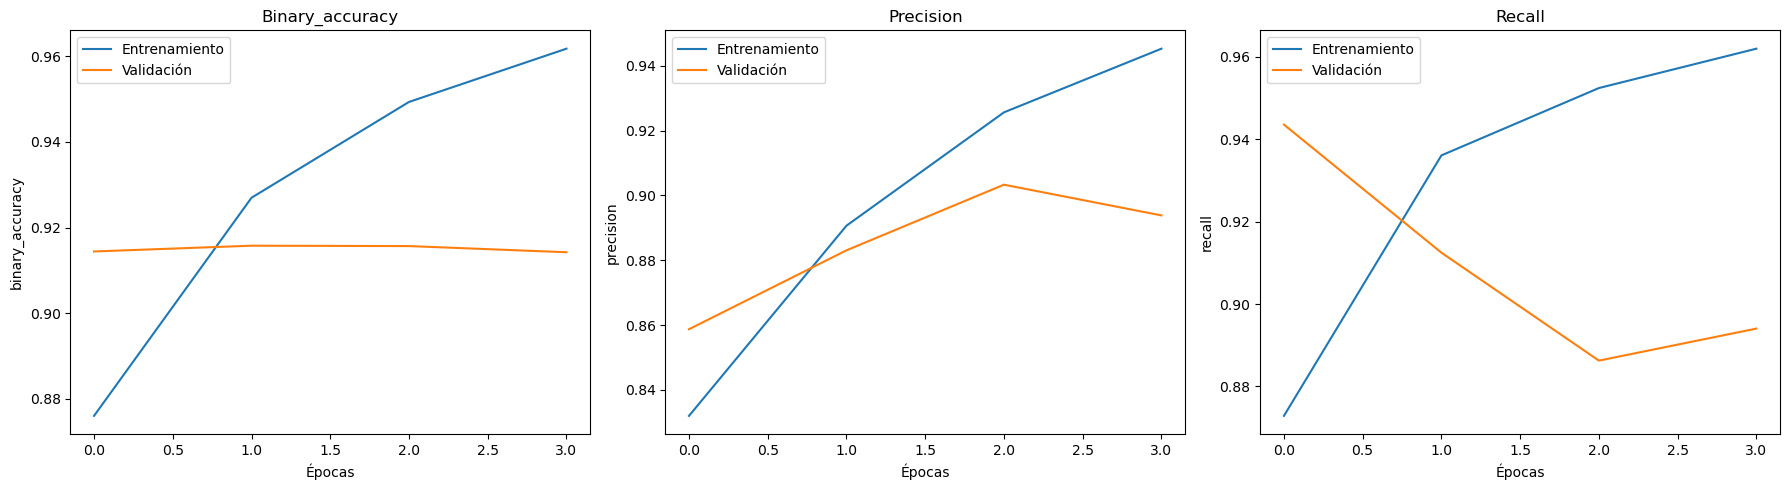

In [18]:
# 1. Construcción del modelo con MobileNetV3
print('build_model...')
#y_bal = y_train
model = build_model(num_classes=len(LABEL_COLUMNS))
print('build_model OK')

#print('loss...')
# Ejemplo de uso:
#class_weights = calculate_class_weights(y_bal, alpha=0.7)
#loss_fn = weighted_binary_crossentropy(class_weights)
#print('loss OK')

# Optimizador con learning rate adaptativo
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# 2. Compilación del modelo
print('compile...')
model.compile(
    optimizer=optimizer,
    #loss=loss_fn,  # Loss estándar para multi-label
    loss='binary_crossentropy',  # Loss estándar para multi-label
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
print('compile OK')


print('fit inicial...')
# Crear generadores
train_df = pd.read_csv(CSV_PATH_DEV)
val_df = pd.read_csv(CSV_PATH_TEST)
print(f'Length dataset {len(train_df)}')
print('distribución train set...')
print_class_distribution_from_csv(CSV_PATH_DEV, label_columns=LABEL_COLUMNS)
print('distribución test set...')
print_class_distribution_from_csv(CSV_PATH_TEST, label_columns=LABEL_COLUMNS)

train_gen = CustomDataGenerator(train_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS)
val_gen = CustomDataGenerator(val_df, BATCH_SIZE, TARGET_SIZE, LOCAL_IMAGE_PATH, label_columns=LABEL_COLUMNS, shuffle=False)

# 3. Entrenamiento inicial (solo capas nuevas)
initial_epochs = 15
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=initial_epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=3, mode='max'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

print('fit inicial OK')
# Llamada a la función para mostrar las gráficas
plot_training_history(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          276512    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496 

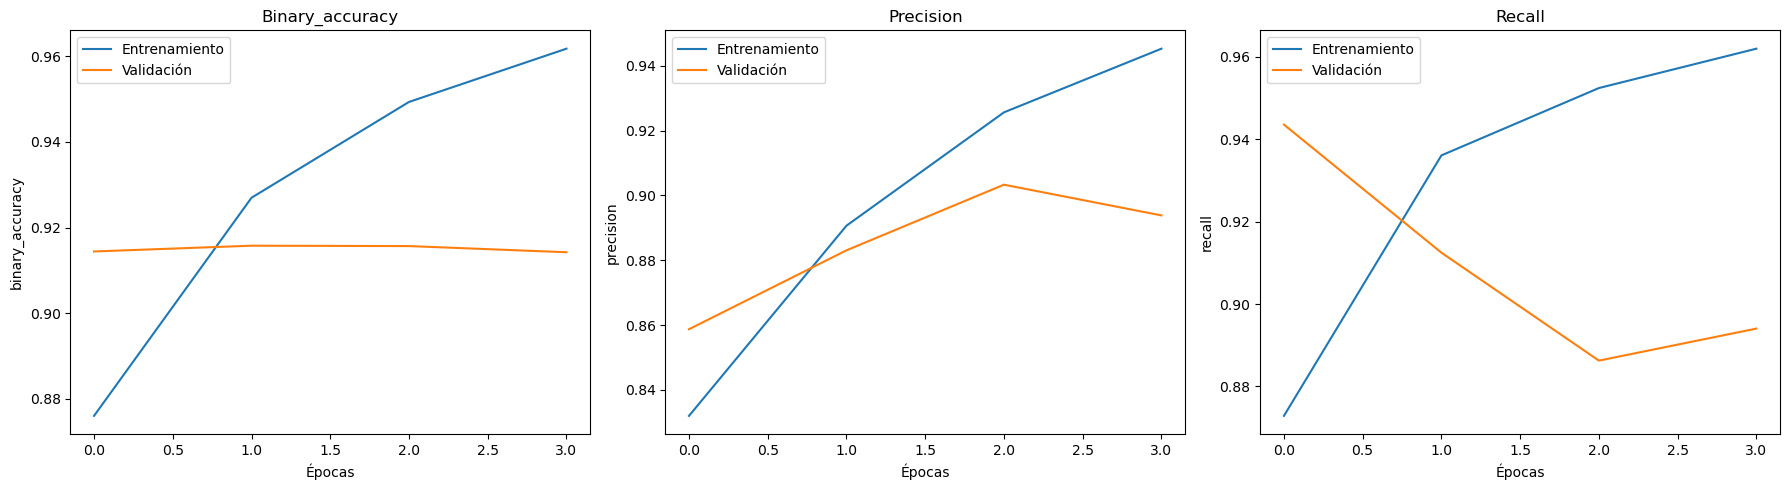

fit OK
save...
save OK


In [19]:
model.summary()

# Ver arquitectura detallada
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# 4. Fine-tuning (descongelar capas superiores)
# Descongelar las últimas 15 capas del modelo base
base_model = model.layers[2]  # Índice de la capa MobileNetV3
base_model.trainable = True
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Recompilar con learning rate más bajo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Entrenar con fine-tuning
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

print('fit...')
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5, mode='max', verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]
)

# Llamada a la función para mostrar las gráficas
plot_training_history(history)
print('fit OK')

# Guardar el modelo entrenado
print('save...')
model.save("mobilenetv3_classifier.v.9.keras")
print('save OK')

In [24]:
from sklearn.metrics import classification_report

print('predict...')
sample_df_test = pd.read_csv(CSV_PATH_TEST)
X_test,y_test = prepare_dataset(sample_df_test, LOCAL_IMAGE_PATH, LABEL_COLUMNS, TARGET_SIZE)   
print(f'X_test={X_test.shape}, y_test={y_test.shape}')
# Dataset de validación sin aumentos
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Generar predicciones
y_pred = model.predict(val_dataset)
y_pred = (y_pred > 0.5).astype(int)
print('predict OK')

# Reporte detallado por clase
print(classification_report(
    y_test,
    y_pred,
    target_names=LABEL_COLUMNS,
    zero_division=0
))

predict...


100%|█████████████████████████████████████████████████████████████████████████████| 2808/2808 [00:12<00:00, 231.33it/s]


X_test=(2808, 224, 224, 3), y_test=(2808, 4)
88/88 [==============================] - 38s 421ms/step
predict OK
              precision    recall  f1-score   support

   direccion       0.80      0.82      0.81       583
     fachada       0.83      0.86      0.84       648
       envio       0.94      0.97      0.96      1880
    etiqueta       0.89      0.89      0.89      1421

   micro avg       0.89      0.91      0.90      4532
   macro avg       0.86      0.89      0.88      4532
weighted avg       0.89      0.91      0.90      4532
 samples avg       0.90      0.92      0.89      4532



1/1 [==============================] - 0s 351ms/step


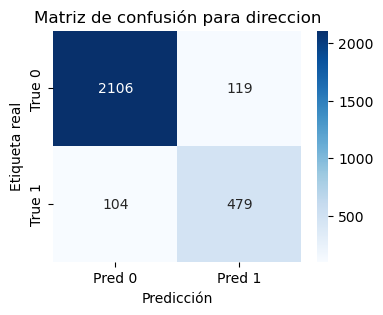

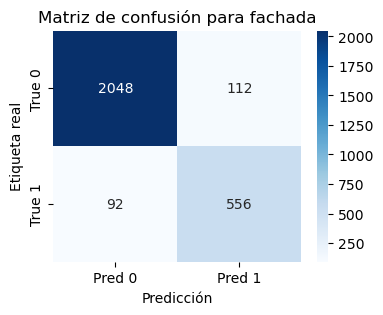

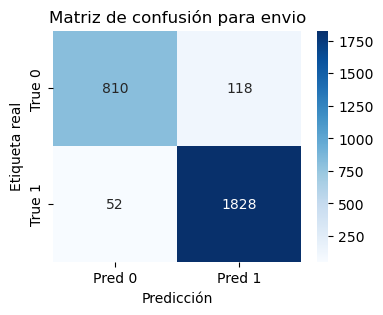

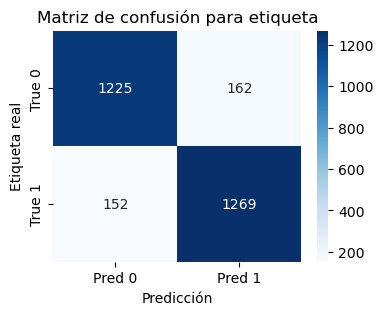

In [25]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Acumula las etiquetas verdaderas y las predicciones en listas
y_true_list = []
y_pred_list = []

# Itera sobre el dataset de validación
for x_batch, y_batch in val_dataset:
    # Genera las predicciones para el batch
    preds = model.predict(x_batch)
    # Convierte las probabilidades a etiquetas binarias (umbral de 0.5, ajústalo si es necesario)
    preds_binary = (preds > 0.5).astype(int)
    
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(preds_binary)

# Concatena todos los batches en arreglos completos
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calcula la matriz de confusión para cada clase
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Recorre y muestra la matriz de confusión de cada clase
for i, cm in enumerate(mcm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Pred 0", "Pred 1"], 
                yticklabels=["True 0", "True 1"])
    plt.title(f"Matriz de confusión para {LABEL_COLUMNS[i]}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.show()
